# Draft Pick and PLayer Evaluator
* Uses fantasy football data and NFL game spreads to estimate value of draft picks
* Brock Ricker
* https://github.com/brock-ricker
* Created 09/18/2022

In [1]:
#import modules here
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sqlalchemy import create_engine, inspect

In [2]:
# create sqlite engine for fantasy_league db
engine = create_engine("sqlite:///fantasy_football_data.db", echo=True)
#create connection to the engine
conn = engine.connect()

# Defining Metrics for Evaluation

In [4]:
#weekly points per player and position query 
sql = """
SELECT sp.name, sp.id, sp.team, sp.position, sp.rookie, wp.score, wp.status, wp.should_start, wp.week, wp.year, wp.regular_season, sp.name
FROM weekly_players as wp
LEFT JOIN simple_players as sp
ON wp.id = sp.id AND wp.year = sp.year
"""

df = pd.read_sql_query(sql, engine)

2022-09-18 16:06:46,338 INFO sqlalchemy.engine.Engine 
SELECT sp.name, sp.id, sp.team, sp.position, sp.rookie, wp.score, wp.status, wp.should_start, wp.week, wp.year, wp.regular_season, sp.name
FROM weekly_players as wp
LEFT JOIN simple_players as sp
ON wp.id = sp.id AND wp.year = sp.year

2022-09-18 16:06:46,338 INFO sqlalchemy.engine.Engine [raw sql] ()


In [5]:
# filtering to starters only
starters = df.loc[df["status"]=="starter"]

# dropping null scores, these are from score  = 0 this means the player most likely started someone they shoud not have
starters = starters.dropna()

#selecting only regular season games
starters = starters.loc[starters["regular_season"]==1]

In [6]:
#calculating score thresholds for different positions
score_25th_list = list()
score_50th_list = list()
score_90th_list = list()

positions = df["position"].unique()
for pos in positions:
    pos_score = starters.loc[(starters["position"] == f"{pos}")]
    score_25th_list.append(pos_score["score"].quantile(q=0.25).round(2))
    score_50th_list.append(pos_score["score"].median())
    score_90th_list.append(pos_score["score"].quantile(q=0.9).round(2))


In [7]:
#converting score thresholds to Data Frame 
pos_metrics = pd.DataFrame({
    "position":positions,
    "score_25th":score_25th_list,
    "score_50th":score_50th_list,
    "score_90th":score_90th_list
})

In [8]:
#saving metrics table to SQL db in order to use it for later pulls
pos_metrics.to_sql("pos_metrics", conn, if_exists="replace")

2022-09-18 16:15:59,182 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("pos_metrics")
2022-09-18 16:15:59,182 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-09-18 16:15:59,183 INFO sqlalchemy.engine.Engine PRAGMA temp.table_info("pos_metrics")
2022-09-18 16:15:59,183 INFO sqlalchemy.engine.Engine [raw sql] ()
2022-09-18 16:15:59,184 INFO sqlalchemy.engine.Engine 
CREATE TABLE pos_metrics (
	"index" BIGINT, 
	position TEXT, 
	score_25th FLOAT, 
	score_50th FLOAT, 
	score_90th FLOAT
)


2022-09-18 16:15:59,184 INFO sqlalchemy.engine.Engine [no key 0.00029s] ()
2022-09-18 16:15:59,200 INFO sqlalchemy.engine.Engine COMMIT
2022-09-18 16:15:59,201 INFO sqlalchemy.engine.Engine CREATE INDEX ix_pos_metrics_index ON pos_metrics ("index")
2022-09-18 16:15:59,201 INFO sqlalchemy.engine.Engine [no key 0.00053s] ()
2022-09-18 16:15:59,211 INFO sqlalchemy.engine.Engine COMMIT
2022-09-18 16:15:59,213 INFO sqlalchemy.engine.Engine INSERT INTO pos_metrics ("index", position, score_25th, score_50

4

# Rookie Draft Pick Evaluation

In [12]:
#Pulling rookie draft data with metrics attached
sql = """
SELECT df.year AS draft_year, df.round AS draft_round, df.pick AS draft_pick, sp.name, sp.position, wp.year, wp.week, wp.score, pm.score_25th, pm.score_50th, pm.score_90th, 
CASE WHEN wp.score < pm.score_25th THEN "Trash Start"
WHEN wp.score  < pm.score_50th THEN "Bad Start"
WHEN wp.score < pm.score_90th THEN "Good Start"
WHEN wp.score >= pm.score_90th THEN "Elite Start"
ELSE "DNP" END AS start_type
FROM draft as df
LEFT JOIN weekly_players as wp
ON df.player = wp.id
LEFT JOIN simple_players AS sp
ON wp.id = sp.id AND wp.year = sp.year
LEFT JOIN pos_metrics AS pm
ON sp.position = pm.position
WHERE NOT df.year = 2017 and NOT df.year = 2022
ORDER BY df.year, df.round, df.pick, wp.year, wp.week
"""

df = pd.read_sql_query(sql, engine)


2022-09-18 17:19:44,860 INFO sqlalchemy.engine.Engine 
SELECT df.year AS draft_year, df.round AS draft_round, df.pick AS draft_pick, sp.name, sp.position, wp.year, wp.week, wp.score, pm.score_25th, pm.score_50th, pm.score_90th, 
CASE WHEN wp.score < pm.score_25th THEN "Trash Start"
WHEN wp.score  < pm.score_50th THEN "Bad Start"
WHEN wp.score < pm.score_90th THEN "Good Start"
WHEN wp.score >= pm.score_90th THEN "Elite Start"
ELSE "DNP" END AS start_type
FROM draft as df
LEFT JOIN weekly_players as wp
ON df.player = wp.id
LEFT JOIN simple_players AS sp
ON wp.id = sp.id AND wp.year = sp.year
LEFT JOIN pos_metrics AS pm
ON sp.position = pm.position
WHERE NOT df.year = 2017 and NOT df.year = 2022
ORDER BY df.year, df.round, df.pick, wp.year, wp.week

2022-09-18 17:19:44,860 INFO sqlalchemy.engine.Engine [raw sql] ()


In [13]:
#converting data types of pick#
df = df.astype({
    "draft_round":int,
    "draft_pick":int
})

In [14]:
#creating total pick number column
df["pick_number"] = (df["draft_round"]-1)*12+df["draft_pick"]

#creating pick "group" this will be used to cluster pick numbers
df["pick_group"] = df["pick_number"].apply(lambda x: math.floor(x/4)+1)

In [15]:
#creating career year column (rookie season = career year 1)
df["career_year"] = df["year"] - df["draft_year"] + 1

In [16]:
#removing odd blanks from starts. This table will be used for start %s and availability
start_numbers = df.loc[~df["year"].isnull()]

In [20]:
#removing ALL blanks from points, I dont want to include DNPs in this.
points = df.dropna()

In [21]:
#creating points above good start number
points["points_above_med"] = points["score"]-points["score_50th"]

C:\Users\brock\AppData\Local\Temp\ipykernel_23524\1860792089.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  points["points_above_med"] = points["score"]-points["score_50th"]


In [28]:
points.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 4683
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   draft_year        3498 non-null   int64  
 1   draft_round       3498 non-null   int32  
 2   draft_pick        3498 non-null   int32  
 3   name              3498 non-null   object 
 4   position          3498 non-null   object 
 5   year              3498 non-null   float64
 6   week              3498 non-null   float64
 7   score             3498 non-null   float64
 8   score_25th        3498 non-null   float64
 9   score_50th        3498 non-null   float64
 10  score_90th        3498 non-null   float64
 11  start_type        3498 non-null   object 
 12  pick_number       3498 non-null   int32  
 13  pick_group        3498 non-null   int64  
 14  career_year       3498 non-null   float64
 15  points_above_med  3498 non-null   float64
dtypes: float64(8), int32(3), int64(2), object(

In [48]:
    #set seaborn style
    sns.set_context('talk')
    plt.style.use('seaborn-dark')

In [57]:
points

,draft_year,draft_round,draft_pick,name,position,year,week,score,score_25th,score_50th,score_90th,start_type,pick_number,pick_group,career_year,points_above_med
0,2018,1,1,"Barkley, Saquon",RB,2018.0,1.0,19.80,6.30,10.90,23.70,Good Start,1,1,1.0,8.90
1,2018,1,1,"Barkley, Saquon",RB,2018.0,2.0,17.80,6.30,10.90,23.70,Good Start,1,1,1.0,6.90
2,2018,1,1,"Barkley, Saquon",RB,2018.0,3.0,20.20,6.30,10.90,23.70,Good Start,1,1,1.0,9.30
3,2018,1,1,"Barkley, Saquon",RB,2018.0,4.0,19.00,6.30,10.90,23.70,Good Start,1,1,1.0,8.10
4,2018,1,1,"Barkley, Saquon",RB,2018.0,5.0,26.90,6.30,10.90,23.70,Elite Start,1,1,1.0,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4679,2021,4,12,"Mills, Davis",QB,2021.0,13.0,3.06,12.94,18.02,28.97,Trash Start,48,13,1.0,-14.96
4680,2021,4,12,"Mills, Davis",QB,2021.0,14.0,18.04,12.94,18.02,28.97,Good Start,48,13,1.0,0.02
4681,2021,4,12,"Mills, Davis",QB,2021.0,15.0,15.56,12.94,18.02,28.97,Bad Start,48,13,1.0,-2.46
4682,2021,4,12,"Mills, Davis",QB,2021.0,16.0,18.06,12.94,18.02,28.97,Good Start,48,13,1.0,0.04


In [71]:
#creating custom dtype for start type ordering
from pandas.api.types import CategoricalDtype
start_type_data = CategoricalDtype(["DNP", "Trash Start", "Bad Start", "Good Start", "Elite Start"], ordered=True)

In [82]:
#draft pick evaluator
def pick_eval(pick,start_number=start_numbers,points=points):
    
    #calculating pick group from pick # input
    pick_group = math.floor(pick/4)+1

    #filtering by pick group
    pick_scores = points.loc[points["pick_group"]==pick_group]
    
    #plotting histogram
    plt.style.use('seaborn-dark')
    plt.figure(figsize= (8,5))
    sns.histplot(data=pick_scores, x="points_above_med", hue="position", multiple="stack",  hue_order=["QB","WR","RB","TE"])
    plt.title(f"Draft Pick #{pick} Starter Score distribution")
    plt.axvline(x=0, color="r", ls= "--")
    plt.xlim(-20,20)

    #filter to specific pick group and groups by start type
    pick_starts = start_numbers.loc[start_numbers["pick_group"]==pick_group].groupby(by=["start_type"],as_index=False).count()

    #deletes eronous columns
    pick_starts = pick_starts[["start_type","week"]]
    #renames column
    pick_starts = pick_starts.rename(columns = {"week":"count"})
    
    # of games since joining leagu
    total_starts = pick_starts["count"].sum()
    
    #calculating start type %
    pick_starts["%"] = (pick_starts["count"]/total_starts).round(2)*100

    #Sorting by start type
    pick_starts["start_type"] = pick_starts["start_type"].astype(start_type_data)
    pick_starts.sort_values(["start_type"], ascending=False, inplace=True)

    return pick_starts


,start_type,count,%
2,Elite Start,9,2.0
3,Good Start,34,7.0
0,Bad Start,64,13.0
4,Trash Start,223,46.0
1,DNP,155,32.0


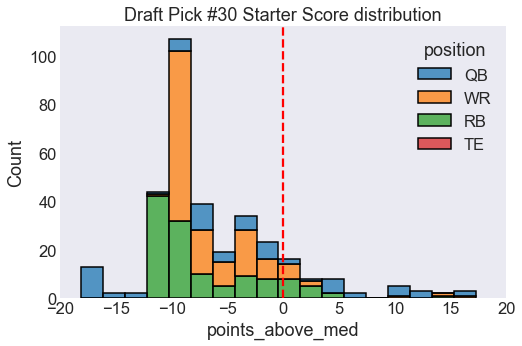

In [83]:
pick_eval(30)

# Player Evaluation

In [84]:
#draft pick evaluator
def player_eval(player,start_number=start_numbers,points=points):
    
    #filtering by player name
    player_scores = points.loc[points["name"]==player]
    
    #plotting histogram
    plt.figure(figsize= (8,5))
    sns.histplot(data=player_scores, x="points_above_med", hue="position", multiple="stack",  hue_order=["QB","WR","RB","TE"])
    plt.title(f"{player}'s Start Score distribution")
    plt.axvline(x=0, color="r", ls= "--")
    plt.xlim(-20,20)

    #filter to specific pick group and groups by start type
    player_starts = start_numbers.loc[start_numbers["name"]==player].groupby(by=["start_type"],as_index=False).count()

    #deletes eronous columns
    player_starts = player_starts[["start_type","week"]]
    #renames column
    player_starts = player_starts.rename(columns = {"week":"count"})
    
    #calculating # of games since joining league
    total_starts = player_starts["count"].sum()
    
    #calculating start type %
    player_starts["%"] = (player_starts["count"]/total_starts).round(2)*100

    #Sorting by start type
    player_starts["start_type"] = player_starts["start_type"].astype(start_type_data)
    player_starts.sort_values(["start_type"], ascending=False, inplace=True)

    return player_starts


,start_type,count,%
2,Elite Start,12,22.0
3,Good Start,20,37.0
0,Bad Start,7,13.0
4,Trash Start,7,13.0
1,DNP,8,15.0


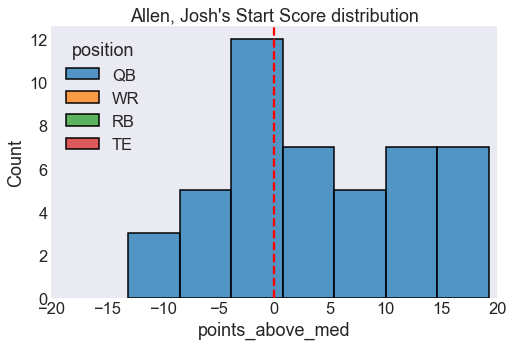

In [85]:
player_eval("Allen, Josh")

In [61]:
points.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3498 entries, 0 to 4683
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   draft_year        3498 non-null   int64  
 1   draft_round       3498 non-null   int32  
 2   draft_pick        3498 non-null   int32  
 3   name              3498 non-null   object 
 4   position          3498 non-null   object 
 5   year              3498 non-null   float64
 6   week              3498 non-null   float64
 7   score             3498 non-null   float64
 8   score_25th        3498 non-null   float64
 9   score_50th        3498 non-null   float64
 10  score_90th        3498 non-null   float64
 11  start_type        3498 non-null   object 
 12  pick_number       3498 non-null   int32  
 13  pick_group        3498 non-null   int64  
 14  career_year       3498 non-null   float64
 15  points_above_med  3498 non-null   float64
dtypes: float64(8), int32(3), int64(2), object(